# pycisTopic analysis

Full dataset, using consensus peak regions.

In [1]:
import pycisTopic
%load_ext nb_black
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import pickle
import pandas as pd
import os

<IPython.core.display.Javascript object>

In [2]:
!pwd

/lustre1/project/stg_00090/scatac_benchmark/fixedcells_4_merged


<IPython.core.display.Javascript object>

In [3]:
wdir = '/lustre1/project/stg_00090/scatac_benchmark/fixedcells_4_merged'
os.chdir( wdir )

<IPython.core.display.Javascript object>

In [4]:
# create output directory:
f_final_dir = os.path.join(wdir, 'downstream_analysis')
if not os.path.exists(f_final_dir):
    os.makedirs(f_final_dir)
    
# create output directory:
for tmpdir in ["binarized_topics", "DARs", "HVRs", "imputed_acc_objs"]:
    tomake = os.path.join(f_final_dir, tmpdir)
    if not os.path.exists(tomake):
        os.makedirs(tomake)
    


<IPython.core.display.Javascript object>

In [5]:
import glob

<IPython.core.display.Javascript object>

## Save/load cisTopic objects

In [6]:
cto_consensus_paths = sorted(glob.glob(f'cistopic_objects_master/*dimreduc.consensus.pkl'))
cistopic_obj_path_dict = {x.split('/')[-1].split(f'__')[0]:x for x in cto_consensus_paths}
cistopic_obj_path_dict

{'master_all_1.FIXEDCELLS': 'cistopic_objects_master/master_all_1.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.model_24topics.dimreduc.consensus.pkl'}

<IPython.core.display.Javascript object>

## Topic binarization & QC

In [7]:
from pycisTopic.topic_binarization import binarize_topics
from pycisTopic.topic_qc import compute_topic_metrics, plot_topic_qc
from pycisTopic.utils import fig2img
import matplotlib.pyplot as plt
from pycisTopic.topic_qc import topic_annotation
from pycisTopic.diff_features import *
from pycisTopic.clust_vis import plot_imputed_features
import numpy as np
import copy

<IPython.core.display.Javascript object>

### Binarize the topic-region distributions

for sample in cistopic_obj_path_dict.keys():
    path = cistopic_obj_path_dict[sample]
    if not os.path.exists(f'downstream_analysis/DARs/{sample}'):
        if os.path.isfile(path):
            print(f"Loading {path}")
            with open(path, 'rb') as f:
                cto = pickle.load(f)

outpath=f"downstream_analysis/imputed_acc_objs/{sample}__imputed_acc_obs.pkl"
if os.path.exists(outpath):
    with open(outpath, 'rb') as f:
        imputed_acc_obj = pickle.load(f)
else:
    print("impute_accessibility")
    imputed_acc_obj = impute_accessibility(
        cto,
        selected_cells=None,
        selected_regions=None,
        scale_factor=10**6
    )

    with open(
        outpath,'wb'
    ) as f:
        pickle.dump(imputed_acc_obj, f, protocol=4)

In [9]:
for sample in cistopic_obj_path_dict.keys():
    path = cistopic_obj_path_dict[sample]
    if not os.path.exists(f'downstream_analysis/DARs/{sample}'):
        if os.path.isfile(path):
            print(f"Loading {path}")
            with open(path, 'rb') as f:
                cto = pickle.load(f)
                
            cto.cell_names = cto.cell_data.index
            if [x.split('-')[0] for x in cto.selected_model.cell_topic.columns] == [x.split('___')[0] for x in list(cto.cell_names)]:
                cto.selected_model.cell_topic.columns =  list(cto.cell_names)
                
            outpath=f"downstream_analysis/binarized_topics/{sample}__topic_region_binarized.pkl"
            if os.path.exists(outpath):
                with open(outpath, 'rb') as f:
                    region_bin_topics = pickle.load(f)
            else:
                region_bin_topics = binarize_topics(
                    cto,
                    method='otsu',
                    ntop=3000,
                    plot=True,
                    num_columns=6,
                    save=f'plots_qc/{sample}__topic_region_binarized.png'
                )

                with open(
                        outpath,'wb'
                ) as f:
                    pickle.dump(region_bin_topics, f, protocol=4)
                    
            outpath=f"downstream_analysis/binarized_topics/{sample}__cells_topic_binarized.pkl"
            if os.path.exists(outpath):
                with open(outpath, 'rb') as f:
                    binarized_cell_topics = pickle.load(f)
            else:
                binarized_cell_topics = binarize_topics(
                    cto,
                    target='cell',
                    method='li',
                    plot=True,
                    num_columns=5,
                    nbins=100,
                    save=f'plots_qc/{sample}__cells_topic_binarized.png'
                )

                with open(
                        outpath,'wb'
                ) as f:
                    pickle.dump(binarized_cell_topics, f, protocol=4)

            outpath=f"downstream_analysis/binarized_topics/{sample}__topic_qc.pkl"
            if os.path.exists(outpath):
                with open(outpath, 'rb') as f:
                    topic_qc_metrics = pickle.load(f)
            else:
                topic_qc_metrics = compute_topic_metrics(cto)
                with open(
                        outpath,'wb'
                ) as f:
                    pickle.dump(topic_qc_metrics, f, protocol=4)

            fig_dict= {
                'CoherenceVSAssignments': plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Log10_Assignments',
                                                        var_color='Gini_index', plot=False, return_fig=True),
                'AssignmentsVSCells_in_bin': plot_topic_qc(topic_qc_metrics, var_x='Log10_Assignments',
                                                           var_y='Cells_in_binarized_topic', var_color='Gini_index',
                                                           plot=False, return_fig=True),
                'CoherenceVSCells_in_bin': plot_topic_qc(topic_qc_metrics, var_x='Coherence',
                                                         var_y='Cells_in_binarized_topic', var_color='Gini_index',
                                                         plot=False, return_fig=True),
                'CoherenceVSRegions_in_bin': plot_topic_qc(topic_qc_metrics, var_x='Coherence',
                                                           var_y='Regions_in_binarized_topic', var_color='Gini_index',
                                                           plot=False, return_fig=True),
                'CoherenceVSMarginal_dist': plot_topic_qc(topic_qc_metrics, var_x='Coherence',
                                                          var_y='Marginal_topic_dist', var_color='Gini_index',
                                                          plot=False, return_fig=True),
                'CoherenceVSGini_index': plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Gini_index',
                                                       var_color='Gini_index', plot=False, return_fig=True)}

            fig=plt.figure(figsize=(40, 43))
            i = 1
            for fig_ in fig_dict.keys():
                plt.subplot(2, 3, i)
                img = fig2img(fig_dict[fig_]) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
                plt.imshow(img)
                plt.axis('off')
                i += 1
            plt.subplots_adjust(wspace=0, hspace=-0.70)
            #plt.tight_layout()
            plt.show()
            plt.savefig(f'plots_qc/{sample}__topic_qc_metrics.png', facecolor='white', dpi=150)
            
            print("topic annotation")
            topic_annot = topic_annotation(
                cto,
                annot_var='consensus_cell_type',
                binarized_cell_topic=binarized_cell_topics,
                general_topic_thr = 0.2
            )
            
            print("topic_qc_metrics")
            topic_qc_metrics = pd.concat(
                [
                    topic_annot[['consensus_cell_type', 'Ratio_cells_in_topic', 'Ratio_group_in_population']],
                    topic_qc_metrics
                ],
                axis=1
            )
            
            outpath=f"downstream_analysis/imputed_acc_objs/{sample}__imputed_acc_obs.pkl"
            if os.path.exists(outpath):
                with open(outpath, 'rb') as f:
                    imputed_acc_obj = pickle.load(f)
            else:
                print("impute_accessibility")
                imputed_acc_obj = impute_accessibility(
                    cto,
                    selected_cells=None,
                    selected_regions=None,
                    scale_factor=10**6
                )

                with open(
                    outpath,'wb'
                ) as f:
                    pickle.dump(imputed_acc_obj, f, protocol=4)
                    
            outpath=f"downstream_analysis/imputed_acc_objs/{sample}__normalized_imputed_acc_obs.pkl"
            if os.path.exists(outpath):
                with open(path, 'rb') as f:
                    normalized_imputed_acc_obj = pickle.load(f)
            else:
                print("normalize_scores")
                normalized_imputed_acc_obj = normalize_scores(
                    imputed_acc_obj,
                    scale_factor=10**4
                )

                with open(
                    f"downstream_analysis/imputed_acc_objs/{sample}__normalized_imputed_acc_obs.pkl",'wb'
                ) as f:
                    pickle.dump(normalized_imputed_acc_obj, f, protocol=4)
                
            print("find_highly_variable_features")
            variable_regions = find_highly_variable_features(
                normalized_imputed_acc_obj,
                min_disp = 0.05,
                min_mean = 0.0125,
                max_mean = 3,
                max_disp = np.inf,
                n_bins=20,
                n_top_features=None,
                plot=True,
                save=f'plots_qc/{sample}__HVR.png'
            )

            print(f"Found {len(variable_regions)} variable regions")
            with open(f'downstream_analysis/HVRs/{sample}__HVRs.bed', 'w') as f:
                for line in [x.replace(':','\t').replace('-','\t') for x in variable_regions]:
                    f.write(f"{line}\t")

            os.mkdir(f'downstream_analysis/DARs/{sample}')
            
            
            outpath=f"downstream_analysis/DARs/{sample}/{sample}__DARs_dict.pkl"
            if os.path.exists(outpath):
                with open(outpath, 'rb') as f:
                    markers_dict = pickle.load(f)
            else:
                markers_dict = find_diff_features(
                    cto,
                    normalized_imputed_acc_obj,
                    variable='consensus_cell_type',
                    var_features=variable_regions,
                    contrasts=None,
                    adjpval_thr=0.05,
                    log2fc_thr=np.log2(1.5),
                    n_cpu=5,
                )
                with open(
                        outpath,'wb'
                ) as f:
                    pickle.dump(markers_dict, f, protocol=4)

                for cell_type in markers_dict.keys():
                    markers = markers_dict[cell_type].index.tolist()
                    df = pd.DataFrame(markers)
                    if len(df) == 0:
                        print(f"no DARs found for {cell_type} in {sample}")
                    else:
                        df[[0,1]] = df[0].str.split(':',expand=True)
                        df[[1,2]] = df[1].str.split('-',expand=True)
                        df[3] = markers_dict[cell_type].index.tolist()
                        df[3] = cell_type.replace(' ', '_')# + '_' + df[3].astype(str)
                        score = markers_dict[cell_type]['Log2FC']
                        score = score.reset_index(drop=True)
                        df[4] = score
                        df[5] = '.'
                        pval = markers_dict[cell_type]['Adjusted_pval']
                        pval = pval.reset_index(drop=True)
                        df[6] = pval
                        name = cell_type.replace(' ', '_')
                        # name = name.replace('/', '-')
                        if not os.path.exists(f'downstream_analysis/DARs/{sample}'):
                            os.mkdir(f'downstream_analysis/DARs/{sample}')

                        df.to_csv(f'downstream_analysis/DARs/{sample}/{sample}__{cell_type.replace(" ", "_")}__DARs.bed', sep='\t', header=False, index=False)
                        df[0:2000].to_csv(f'downstream_analysis/DARs/{sample}/{sample}__{cell_type.replace(" ", "_")}__DARs.TOP2k.bed', sep='\t', header=False, index=False)

        else:
            print(f'{path} does not exist!')
    else:
        print(f"downstream_analysis/DARs/{sample} already exists!")

downstream_analysis/DARs/master_all_1.FIXEDCELLS already exists!


<IPython.core.display.Javascript object>

# visualise dars

markers_path_dict = {x.split('/')[-1].split(f'__')[0]:x for x in sorted(glob.glob(f'downstream_analysis/DARs/*/*.pkl'))}
markers_path_dict

imputed_acc_obj_dict = {x.split('/')[-1].split(f'__')[0]:x for x in sorted(glob.glob(f'downstream_analysis/imputed_acc_objs/*.pkl'))}
imputed_acc_obj_dict

for sample in markers_path_dict.keys():
    print(sample)
    fig_path = f'plots_qc/{sample}_DAR_umap.png'
    if not os.path.exists(fig_path):
        with open(cistopic_obj_path_dict[sample], 'rb') as f:
            cto = pickle.load(f)

        with open(imputed_acc_obj_dict[sample], 'rb') as f:
            imputed_acc_obj = pickle.load(f)

        with open(markers_path_dict[sample], 'rb') as f:
            markers_dict = pickle.load(f)

        [ print(x + ': '+ str(len(markers_dict[x]))) for x in markers_dict.keys() ]
        plot_imputed_features(
            cto,
            reduction_name='UMAP',
            imputed_data=imputed_acc_obj,
            features=[markers_dict[x].index.tolist()[0] for x in markers_dict.keys() if len(markers_dict[x])> 0],
            scale=False,
            num_columns=3,
            selected_cells = cto.projections['cell']['UMAP'].index.tolist(),
            save=fig_path
        )
    else:
        print(f"\t{fig_path} already exists")

# calculate DARs within cell types between techniques

import seaborn as sns

test_df = df.groupby('seurat_cell_type')['consensus_cell_type'].value_counts().unstack().fillna(0)
test_df_normalized = test_df.div(test_df.sum(axis=1), axis=0)

sns.heatmap(test_df_normalized)
plt.tight_layout()
plt.savefig('plots_pub/cell_origin_heatmap.png', dpi=600, facecolor='white')

In [10]:
with open("cistopic_objects_master/master_all_1.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.model_24topics.dimreduc.consensus.pkl", 'rb') as f:
    cto = pickle.load(f)

<IPython.core.display.Javascript object>

In [11]:
with open("downstream_analysis/imputed_acc_objs/master_all_1.FIXEDCELLS__normalized_imputed_acc_obs.pkl", 'rb') as f:
    normalized_imputed_acc_obj = pickle.load(f)

<IPython.core.display.Javascript object>

find_highly_variable_features
2022-12-22 14:35:03,967 cisTopic     INFO     Calculating mean
2022-12-22 14:35:43,346 cisTopic     INFO     Calculating variance


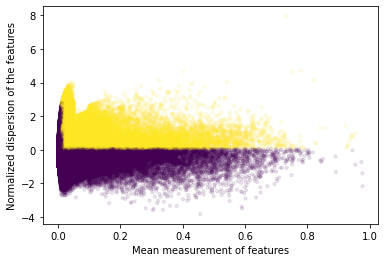

2022-12-22 14:39:11,238 cisTopic     INFO     Done!


<IPython.core.display.Javascript object>

In [12]:
print("find_highly_variable_features")
variable_regions = find_highly_variable_features(
    normalized_imputed_acc_obj,
    min_disp = 0.05,
    min_mean = 0.0125,
    max_mean = 3,
    max_disp = np.inf,
    n_bins=20,
    n_top_features=None,
    plot=True,
    save=f'plots_qc/{sample}__HVR.png'
)

In [13]:
for cell_type in cto.cell_data['consensus_cell_type__mega'].unique():
    print(cell_type)
    # df_sub = df[df['consensus_cell_type'] == cell_type]
    cto.cell_data["contrast"] = "ignore"
    cto.cell_data.loc[cto.cell_data['consensus_cell_type__mega'] == cell_type, 'contrast'] = f"{cell_type.replace(' ', '_')}_in_othertechs"
    
    for tech in cto.cell_data.loc[cto.cell_data['consensus_cell_type__mega'] == cell_type]['tech'].unique():
        print(f"\t{tech}")
        outpath = f"celltype_tech_DARs/{tech}__{cell_type.replace(' ','_')}__1-2xfoldchange_DARs.bed"
        
        if not os.path.exists(outpath):
            cto.cell_data.loc[(cto.cell_data['tech'] == tech) & (cto.cell_data['consensus_cell_type__mega'] == cell_type), 'contrast'] = f"{cell_type.replace(' ', '_')}_in_{tech}"
            
            print(cto.cell_data.groupby("consensus_cell_type__mega")['contrast'].value_counts())
            
            contrast = [[[f"{cell_type.replace(' ', '_')}_in_{tech}"], [f"{cell_type.replace(' ', '_')}_in_othertechs"]]]
            markers_dict = find_diff_features(
                cto,
                normalized_imputed_acc_obj,
                variable='contrast',
                var_features=variable_regions,
                contrasts=contrast,
                adjpval_thr=0.05,
                log2fc_thr=np.log2(1.2),
                n_cpu=10,
            )

            for contrast in markers_dict.keys():
                markers = markers_dict[contrast].index.tolist()
                df = pd.DataFrame(markers)

                if len(df) == 0:
                    print(f"\t\tno DARs found for {contrast} in {sample}")

                else:
                    df[[0,1]] = df[0].str.split(':',expand=True)
                    df[[1,2]] = df[1].str.split('-',expand=True)
                    df[3] = markers_dict[contrast].index.tolist()
                    df[3] = contrast.replace(' ', '_')# + '_' + df[3].astype(str)
                    score = markers_dict[contrast]['Log2FC']
                    score = score.reset_index(drop=True)
                    df[4] = score
                    df[5] = '.'
                    pval = markers_dict[contrast]['Adjusted_pval']
                    pval = pval.reset_index(drop=True)
                    df[6] = pval
                    name = contrast.replace(' ', '_')

                    df.to_csv(outpath, sep='\t', header=False, index=False)
                    
        cto.cell_data.loc[cto.cell_data['consensus_cell_type__mega'] == cell_type, 'contrast'] = "background"

Cytotoxic T cell
	s3atac
	10xmultiome
consensus_cell_type__mega  contrast                       
B cell                     ignore                             15339
CD14+ monocyte             ignore                             38490
CD16+ monocyte             ignore                              4402
CD4+ T cell                ignore                             49336
Cytotoxic T cell           background                         46563
                           Cytotoxic_T_cell_in_10xmultiome     2740
Dendritic cell             ignore                              2624
Natural killer cell        ignore                              9733
Name: contrast, dtype: int64


2022-12-22 14:40:34,562	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2059155) 2022-12-22 14:40:56,086 cisTopic     INFO     Formatting data for Cytotoxic_T_cell_in_10xmultiome_VS_Cytotoxic_T_cell_in_othertechs


(markers_ray pid=2059155) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2059155)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2059155) 2022-12-22 14:41:01,482 cisTopic     INFO     Computing p-value for Cytotoxic_T_cell_in_10xmultiome_VS_Cytotoxic_T_cell_in_othertechs
(markers_ray pid=2059155) 2022-12-22 14:41:39,773 cisTopic     INFO     Computing log2FC for Cytotoxic_T_cell_in_10xmultiome_VS_Cytotoxic_T_cell_in_othertechs


(markers_ray pid=2059155) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2059155)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2059155) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2059155)   ret = um.true_divide(


(markers_ray pid=2059155) 2022-12-22 14:41:41,362 cisTopic     INFO     Cytotoxic_T_cell_in_10xmultiome_VS_Cytotoxic_T_cell_in_othertechs done!
		no DARs found for Cytotoxic_T_cell_in_10xmultiome_VS_Cytotoxic_T_cell_in_othertechs in master_all_1.FIXEDCELLS
	10xv11
consensus_cell_type__mega  contrast                  
B cell                     ignore                        15339
CD14+ monocyte             ignore                        38490
CD16+ monocyte             ignore                         4402
CD4+ T cell                ignore                        49336
Cytotoxic T cell           background                    44812
                           Cytotoxic_T_cell_in_10xv11     4491
Dendritic cell             ignore                         2624
Natural killer cell        ignore                         9733
Name: contrast, dtype: int64


2022-12-22 14:42:51,742	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2065613) 2022-12-22 14:43:11,487 cisTopic     INFO     Formatting data for Cytotoxic_T_cell_in_10xv11_VS_Cytotoxic_T_cell_in_othertechs


(markers_ray pid=2065613) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2065613)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2065613) 2022-12-22 14:43:20,383 cisTopic     INFO     Computing p-value for Cytotoxic_T_cell_in_10xv11_VS_Cytotoxic_T_cell_in_othertechs
(markers_ray pid=2065613) 2022-12-22 14:44:08,516 cisTopic     INFO     Computing log2FC for Cytotoxic_T_cell_in_10xv11_VS_Cytotoxic_T_cell_in_othertechs


(markers_ray pid=2065613) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2065613)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2065613) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2065613)   ret = um.true_divide(


(markers_ray pid=2065613) 2022-12-22 14:44:10,161 cisTopic     INFO     Cytotoxic_T_cell_in_10xv11_VS_Cytotoxic_T_cell_in_othertechs done!
		no DARs found for Cytotoxic_T_cell_in_10xv11_VS_Cytotoxic_T_cell_in_othertechs in master_all_1.FIXEDCELLS
	hydrop
consensus_cell_type__mega  contrast                  
B cell                     ignore                        15339
CD14+ monocyte             ignore                        38490
CD16+ monocyte             ignore                         4402
CD4+ T cell                ignore                        49336
Cytotoxic T cell           background                    39560
                           Cytotoxic_T_cell_in_hydrop     9743
Dendritic cell             ignore                         2624
Natural killer cell        ignore                         9733
Name: contrast, dtype: int64


2022-12-22 14:45:33,714	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2075614) 2022-12-22 14:45:53,370 cisTopic     INFO     Formatting data for Cytotoxic_T_cell_in_hydrop_VS_Cytotoxic_T_cell_in_othertechs
(markers_ray pid=2075614) 2022-12-22 14:46:11,664 cisTopic     INFO     Computing p-value for Cytotoxic_T_cell_in_hydrop_VS_Cytotoxic_T_cell_in_othertechs


(markers_ray pid=2075614) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2075614)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2075614) 2022-12-22 14:47:28,445 cisTopic     INFO     Computing log2FC for Cytotoxic_T_cell_in_hydrop_VS_Cytotoxic_T_cell_in_othertechs


(markers_ray pid=2075614) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2075614)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2075614) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2075614)   ret = um.true_divide(


		no DARs found for Cytotoxic_T_cell_in_hydrop_VS_Cytotoxic_T_cell_in_othertechs in master_all_1.FIXEDCELLS
	10xv2
consensus_cell_type__mega  contrast                 
B cell                     ignore                       15339
CD14+ monocyte             ignore                       38490
CD16+ monocyte             ignore                        4402
CD4+ T cell                ignore                       49336
Cytotoxic T cell           background                   42795
                           Cytotoxic_T_cell_in_10xv2     6508
Dendritic cell             ignore                        2624
Natural killer cell        ignore                        9733
Name: contrast, dtype: int64


2022-12-22 14:48:41,600	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2084586) 2022-12-22 14:49:01,025 cisTopic     INFO     Formatting data for Cytotoxic_T_cell_in_10xv2_VS_Cytotoxic_T_cell_in_othertechs


(markers_ray pid=2084586) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2084586)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2084586) 2022-12-22 14:49:12,076 cisTopic     INFO     Computing p-value for Cytotoxic_T_cell_in_10xv2_VS_Cytotoxic_T_cell_in_othertechs
(markers_ray pid=2084586) 2022-12-22 14:50:09,250 cisTopic     INFO     Computing log2FC for Cytotoxic_T_cell_in_10xv2_VS_Cytotoxic_T_cell_in_othertechs


(markers_ray pid=2084586) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2084586)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2084586) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2084586)   ret = um.true_divide(


		no DARs found for Cytotoxic_T_cell_in_10xv2_VS_Cytotoxic_T_cell_in_othertechs in master_all_1.FIXEDCELLS
	ddseq
consensus_cell_type__mega  contrast                 
B cell                     ignore                       15339
CD14+ monocyte             ignore                       38490
CD16+ monocyte             ignore                        4402
CD4+ T cell                ignore                       49336
Cytotoxic T cell           background                   39011
                           Cytotoxic_T_cell_in_ddseq    10292
Dendritic cell             ignore                        2624
Natural killer cell        ignore                        9733
Name: contrast, dtype: int64


2022-12-22 14:51:28,888	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2089367) 2022-12-22 14:51:48,503 cisTopic     INFO     Formatting data for Cytotoxic_T_cell_in_ddseq_VS_Cytotoxic_T_cell_in_othertechs


(markers_ray pid=2089367) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2089367)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2089367) 2022-12-22 14:52:05,253 cisTopic     INFO     Computing p-value for Cytotoxic_T_cell_in_ddseq_VS_Cytotoxic_T_cell_in_othertechs
(markers_ray pid=2089367) 2022-12-22 14:53:20,628 cisTopic     INFO     Computing log2FC for Cytotoxic_T_cell_in_ddseq_VS_Cytotoxic_T_cell_in_othertechs


(markers_ray pid=2089367) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2089367)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2089367) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2089367)   ret = um.true_divide(


(markers_ray pid=2089367) 2022-12-22 14:53:22,435 cisTopic     INFO     Cytotoxic_T_cell_in_ddseq_VS_Cytotoxic_T_cell_in_othertechs done!
		no DARs found for Cytotoxic_T_cell_in_ddseq_VS_Cytotoxic_T_cell_in_othertechs in master_all_1.FIXEDCELLS
	mtscatac
consensus_cell_type__mega  contrast                    
B cell                     ignore                          15339
CD14+ monocyte             ignore                          38490
CD16+ monocyte             ignore                           4402
CD4+ T cell                ignore                          49336
Cytotoxic T cell           background                      39469
                           Cytotoxic_T_cell_in_mtscatac     9834
Dendritic cell             ignore                           2624
Natural killer cell        ignore                           9733
Name: contrast, dtype: int64


2022-12-22 14:54:29,791	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2090870) 2022-12-22 14:54:49,312 cisTopic     INFO     Formatting data for Cytotoxic_T_cell_in_mtscatac_VS_Cytotoxic_T_cell_in_othertechs
(markers_ray pid=2090870) 2022-12-22 14:55:04,145 cisTopic     INFO     Computing p-value for Cytotoxic_T_cell_in_mtscatac_VS_Cytotoxic_T_cell_in_othertechs


(markers_ray pid=2090870) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2090870)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2090870) 2022-12-22 14:56:20,040 cisTopic     INFO     Computing log2FC for Cytotoxic_T_cell_in_mtscatac_VS_Cytotoxic_T_cell_in_othertechs


(markers_ray pid=2090870) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2090870)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2090870) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2090870)   ret = um.true_divide(


		no DARs found for Cytotoxic_T_cell_in_mtscatac_VS_Cytotoxic_T_cell_in_othertechs in master_all_1.FIXEDCELLS
	10xv1
consensus_cell_type__mega  contrast                 
B cell                     ignore                       15339
CD14+ monocyte             ignore                       38490
CD16+ monocyte             ignore                        4402
CD4+ T cell                ignore                       49336
Cytotoxic T cell           background                   47728
                           Cytotoxic_T_cell_in_10xv1     1575
Dendritic cell             ignore                        2624
Natural killer cell        ignore                        9733
Name: contrast, dtype: int64


2022-12-22 14:57:32,772	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2201514) 2022-12-22 14:57:52,525 cisTopic     INFO     Formatting data for Cytotoxic_T_cell_in_10xv1_VS_Cytotoxic_T_cell_in_othertechs


(markers_ray pid=2201514) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2201514)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2201514) 2022-12-22 14:57:54,836 cisTopic     INFO     Computing p-value for Cytotoxic_T_cell_in_10xv1_VS_Cytotoxic_T_cell_in_othertechs


(markers_ray pid=2201514) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2201514)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2201514) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2201514)   ret = um.true_divide(


(markers_ray pid=2201514) 2022-12-22 14:58:28,027 cisTopic     INFO     Computing log2FC for Cytotoxic_T_cell_in_10xv1_VS_Cytotoxic_T_cell_in_othertechs
		no DARs found for Cytotoxic_T_cell_in_10xv1_VS_Cytotoxic_T_cell_in_othertechs in master_all_1.FIXEDCELLS
B cell
	s3atac
	10xmultiome
consensus_cell_type__mega  contrast             
B cell                     background               13560
                           B_cell_in_10xmultiome     1779
CD14+ monocyte             ignore                   38490
CD16+ monocyte             ignore                    4402
CD4+ T cell                ignore                   49336
Cytotoxic T cell           ignore                   49303
Dendritic cell             ignore                    2624
Natural killer cell        ignore                    9733
Name: contrast, dtype: int64


2022-12-22 14:59:42,455	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2202363) 2022-12-22 15:00:01,966 cisTopic     INFO     Formatting data for B_cell_in_10xmultiome_VS_B_cell_in_othertechs
(markers_ray pid=2202363) 2022-12-22 15:00:07,131 cisTopic     INFO     Computing p-value for B_cell_in_10xmultiome_VS_B_cell_in_othertechs


(markers_ray pid=2202363) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2202363)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2202363) 2022-12-22 15:00:40,933 cisTopic     INFO     Computing log2FC for B_cell_in_10xmultiome_VS_B_cell_in_othertechs


(markers_ray pid=2202363) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2202363)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2202363) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2202363)   ret = um.true_divide(


		no DARs found for B_cell_in_10xmultiome_VS_B_cell_in_othertechs in master_all_1.FIXEDCELLS
	10xv11
consensus_cell_type__mega  contrast        
B cell                     background          13268
                           B_cell_in_10xv11     2071
CD14+ monocyte             ignore              38490
CD16+ monocyte             ignore               4402
CD4+ T cell                ignore              49336
Cytotoxic T cell           ignore              49303
Dendritic cell             ignore               2624
Natural killer cell        ignore               9733
Name: contrast, dtype: int64


2022-12-22 15:01:57,475	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2312398) 2022-12-22 15:02:18,366 cisTopic     INFO     Formatting data for B_cell_in_10xv11_VS_B_cell_in_othertechs


(markers_ray pid=2312398) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2312398)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2312398) 2022-12-22 15:02:24,628 cisTopic     INFO     Computing p-value for B_cell_in_10xv11_VS_B_cell_in_othertechs
(markers_ray pid=2312398) 2022-12-22 15:03:00,516 cisTopic     INFO     Computing log2FC for B_cell_in_10xv11_VS_B_cell_in_othertechs


(markers_ray pid=2312398) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2312398)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2312398) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2312398)   ret = um.true_divide(


		no DARs found for B_cell_in_10xv11_VS_B_cell_in_othertechs in master_all_1.FIXEDCELLS
	hydrop
consensus_cell_type__mega  contrast        
B cell                     background          13580
                           B_cell_in_hydrop     1759
CD14+ monocyte             ignore              38490
CD16+ monocyte             ignore               4402
CD4+ T cell                ignore              49336
Cytotoxic T cell           ignore              49303
Dendritic cell             ignore               2624
Natural killer cell        ignore               9733
Name: contrast, dtype: int64


2022-12-22 15:04:17,079	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2422483) 2022-12-22 15:04:34,473 cisTopic     INFO     Formatting data for B_cell_in_hydrop_VS_B_cell_in_othertechs
(markers_ray pid=2422483) 2022-12-22 15:04:39,835 cisTopic     INFO     Computing p-value for B_cell_in_hydrop_VS_B_cell_in_othertechs


(markers_ray pid=2422483) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2422483)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2422483) 2022-12-22 15:05:13,260 cisTopic     INFO     Computing log2FC for B_cell_in_hydrop_VS_B_cell_in_othertechs


(markers_ray pid=2422483) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2422483)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2422483) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2422483)   ret = um.true_divide(


		no DARs found for B_cell_in_hydrop_VS_B_cell_in_othertechs in master_all_1.FIXEDCELLS
	10xv2
consensus_cell_type__mega  contrast       
B cell                     background         12588
                           B_cell_in_10xv2     2751
CD14+ monocyte             ignore             38490
CD16+ monocyte             ignore              4402
CD4+ T cell                ignore             49336
Cytotoxic T cell           ignore             49303
Dendritic cell             ignore              2624
Natural killer cell        ignore              9733
Name: contrast, dtype: int64


2022-12-22 15:06:31,534	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2423233) 2022-12-22 15:06:52,444 cisTopic     INFO     Formatting data for B_cell_in_10xv2_VS_B_cell_in_othertechs


(markers_ray pid=2423233) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2423233)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2423233) 2022-12-22 15:07:00,179 cisTopic     INFO     Computing p-value for B_cell_in_10xv2_VS_B_cell_in_othertechs
(markers_ray pid=2423233) 2022-12-22 15:07:39,224 cisTopic     INFO     Computing log2FC for B_cell_in_10xv2_VS_B_cell_in_othertechs


(markers_ray pid=2423233) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2423233)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2423233) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2423233)   ret = um.true_divide(


(markers_ray pid=2423233) 2022-12-22 15:07:40,873 cisTopic     INFO     B_cell_in_10xv2_VS_B_cell_in_othertechs done!
		no DARs found for B_cell_in_10xv2_VS_B_cell_in_othertechs in master_all_1.FIXEDCELLS
	ddseq
consensus_cell_type__mega  contrast       
B cell                     background         12076
                           B_cell_in_ddseq     3263
CD14+ monocyte             ignore             38490
CD16+ monocyte             ignore              4402
CD4+ T cell                ignore             49336
Cytotoxic T cell           ignore             49303
Dendritic cell             ignore              2624
Natural killer cell        ignore              9733
Name: contrast, dtype: int64


2022-12-22 15:08:49,703	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2423980) 2022-12-22 15:09:08,029 cisTopic     INFO     Formatting data for B_cell_in_ddseq_VS_B_cell_in_othertechs
(markers_ray pid=2423980) 2022-12-22 15:09:17,026 cisTopic     INFO     Computing p-value for B_cell_in_ddseq_VS_B_cell_in_othertechs


(markers_ray pid=2423980) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2423980)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2423980) 2022-12-22 15:09:57,352 cisTopic     INFO     Computing log2FC for B_cell_in_ddseq_VS_B_cell_in_othertechs


(markers_ray pid=2423980) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2423980)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2423980) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2423980)   ret = um.true_divide(


		no DARs found for B_cell_in_ddseq_VS_B_cell_in_othertechs in master_all_1.FIXEDCELLS
	mtscatac
consensus_cell_type__mega  contrast          
B cell                     background            13185
                           B_cell_in_mtscatac     2154
CD14+ monocyte             ignore                38490
CD16+ monocyte             ignore                 4402
CD4+ T cell                ignore                49336
Cytotoxic T cell           ignore                49303
Dendritic cell             ignore                 2624
Natural killer cell        ignore                 9733
Name: contrast, dtype: int64


2022-12-22 15:11:08,957	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2424628) 2022-12-22 15:11:26,980 cisTopic     INFO     Formatting data for B_cell_in_mtscatac_VS_B_cell_in_othertechs
(markers_ray pid=2424628) 2022-12-22 15:11:33,917 cisTopic     INFO     Computing p-value for B_cell_in_mtscatac_VS_B_cell_in_othertechs


(markers_ray pid=2424628) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2424628)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2424628) 2022-12-22 15:12:09,534 cisTopic     INFO     Computing log2FC for B_cell_in_mtscatac_VS_B_cell_in_othertechs


(markers_ray pid=2424628) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2424628)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2424628) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2424628)   ret = um.true_divide(


(markers_ray pid=2424628) 2022-12-22 15:12:11,159 cisTopic     INFO     B_cell_in_mtscatac_VS_B_cell_in_othertechs done!
		no DARs found for B_cell_in_mtscatac_VS_B_cell_in_othertechs in master_all_1.FIXEDCELLS
	10xv1
consensus_cell_type__mega  contrast       
B cell                     background         14328
                           B_cell_in_10xv1     1011
CD14+ monocyte             ignore             38490
CD16+ monocyte             ignore              4402
CD4+ T cell                ignore             49336
Cytotoxic T cell           ignore             49303
Dendritic cell             ignore              2624
Natural killer cell        ignore              9733
Name: contrast, dtype: int64


2022-12-22 15:13:25,740	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2425594) 2022-12-22 15:13:42,910 cisTopic     INFO     Formatting data for B_cell_in_10xv1_VS_B_cell_in_othertechs
(markers_ray pid=2425594) 2022-12-22 15:13:45,542 cisTopic     INFO     Computing p-value for B_cell_in_10xv1_VS_B_cell_in_othertechs


(markers_ray pid=2425594) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2425594)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2425594) 2022-12-22 15:14:15,236 cisTopic     INFO     Computing log2FC for B_cell_in_10xv1_VS_B_cell_in_othertechs


(markers_ray pid=2425594) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2425594)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2425594) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2425594)   ret = um.true_divide(


		no DARs found for B_cell_in_10xv1_VS_B_cell_in_othertechs in master_all_1.FIXEDCELLS
CD14+ monocyte
	s3atac
	10xmultiome
consensus_cell_type__mega  contrast                     
B cell                     ignore                           15339
CD14+ monocyte             background                       34854
                           CD14+_monocyte_in_10xmultiome     3636
CD16+ monocyte             ignore                            4402
CD4+ T cell                ignore                           49336
Cytotoxic T cell           ignore                           49303
Dendritic cell             ignore                            2624
Natural killer cell        ignore                            9733
Name: contrast, dtype: int64


2022-12-22 15:15:29,463	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2426509) 2022-12-22 15:15:47,726 cisTopic     INFO     Formatting data for CD14+_monocyte_in_10xmultiome_VS_CD14+_monocyte_in_othertechs
(markers_ray pid=2426509) 2022-12-22 15:15:56,035 cisTopic     INFO     Computing p-value for CD14+_monocyte_in_10xmultiome_VS_CD14+_monocyte_in_othertechs


(markers_ray pid=2426509) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2426509)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2426509) 2022-12-22 15:16:40,648 cisTopic     INFO     Computing log2FC for CD14+_monocyte_in_10xmultiome_VS_CD14+_monocyte_in_othertechs


(markers_ray pid=2426509) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2426509)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2426509) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2426509)   ret = um.true_divide(


(markers_ray pid=2426509) 2022-12-22 15:16:42,334 cisTopic     INFO     CD14+_monocyte_in_10xmultiome_VS_CD14+_monocyte_in_othertechs done!
		no DARs found for CD14+_monocyte_in_10xmultiome_VS_CD14+_monocyte_in_othertechs in master_all_1.FIXEDCELLS
	10xv11
consensus_cell_type__mega  contrast                
B cell                     ignore                      15339
CD14+ monocyte             background                  32616
                           CD14+_monocyte_in_10xv11     5874
CD16+ monocyte             ignore                       4402
CD4+ T cell                ignore                      49336
Cytotoxic T cell           ignore                      49303
Dendritic cell             ignore                       2624
Natural killer cell        ignore                       9733
Name: contrast, dtype: int64


2022-12-22 15:17:47,668	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2427222) 2022-12-22 15:18:06,893 cisTopic     INFO     Formatting data for CD14+_monocyte_in_10xv11_VS_CD14+_monocyte_in_othertechs
(markers_ray pid=2427222) 2022-12-22 15:18:17,273 cisTopic     INFO     Computing p-value for CD14+_monocyte_in_10xv11_VS_CD14+_monocyte_in_othertechs


(markers_ray pid=2427222) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2427222)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2427222) 2022-12-22 15:19:15,936 cisTopic     INFO     Computing log2FC for CD14+_monocyte_in_10xv11_VS_CD14+_monocyte_in_othertechs


(markers_ray pid=2427222) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2427222)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2427222) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2427222)   ret = um.true_divide(


		no DARs found for CD14+_monocyte_in_10xv11_VS_CD14+_monocyte_in_othertechs in master_all_1.FIXEDCELLS
	hydrop
consensus_cell_type__mega  contrast                
B cell                     ignore                      15339
CD14+ monocyte             background                  31210
                           CD14+_monocyte_in_hydrop     7280
CD16+ monocyte             ignore                       4402
CD4+ T cell                ignore                      49336
Cytotoxic T cell           ignore                      49303
Dendritic cell             ignore                       2624
Natural killer cell        ignore                       9733
Name: contrast, dtype: int64


2022-12-22 15:20:23,644	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2428051) 2022-12-22 15:20:43,091 cisTopic     INFO     Formatting data for CD14+_monocyte_in_hydrop_VS_CD14+_monocyte_in_othertechs
(markers_ray pid=2428051) 2022-12-22 15:20:54,353 cisTopic     INFO     Computing p-value for CD14+_monocyte_in_hydrop_VS_CD14+_monocyte_in_othertechs


(markers_ray pid=2428051) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2428051)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2428051) 2022-12-22 15:22:02,786 cisTopic     INFO     Computing log2FC for CD14+_monocyte_in_hydrop_VS_CD14+_monocyte_in_othertechs


(markers_ray pid=2428051) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2428051)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2428051) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2428051)   ret = um.true_divide(


		no DARs found for CD14+_monocyte_in_hydrop_VS_CD14+_monocyte_in_othertechs in master_all_1.FIXEDCELLS
	10xv2
consensus_cell_type__mega  contrast               
B cell                     ignore                     15339
CD14+ monocyte             background                 30414
                           CD14+_monocyte_in_10xv2     8076
CD16+ monocyte             ignore                      4402
CD4+ T cell                ignore                     49336
Cytotoxic T cell           ignore                     49303
Dendritic cell             ignore                      2624
Natural killer cell        ignore                      9733
Name: contrast, dtype: int64


2022-12-22 15:23:10,018	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2428848) 2022-12-22 15:23:29,575 cisTopic     INFO     Formatting data for CD14+_monocyte_in_10xv2_VS_CD14+_monocyte_in_othertechs
(markers_ray pid=2428848) 2022-12-22 15:23:42,827 cisTopic     INFO     Computing p-value for CD14+_monocyte_in_10xv2_VS_CD14+_monocyte_in_othertechs


(markers_ray pid=2428848) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2428848)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2428848) 2022-12-22 15:24:53,782 cisTopic     INFO     Computing log2FC for CD14+_monocyte_in_10xv2_VS_CD14+_monocyte_in_othertechs


(markers_ray pid=2428848) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2428848)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2428848) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2428848)   ret = um.true_divide(


		no DARs found for CD14+_monocyte_in_10xv2_VS_CD14+_monocyte_in_othertechs in master_all_1.FIXEDCELLS
	ddseq
consensus_cell_type__mega  contrast               
B cell                     ignore                     15339
CD14+ monocyte             background                 31660
                           CD14+_monocyte_in_ddseq     6830
CD16+ monocyte             ignore                      4402
CD4+ T cell                ignore                     49336
Cytotoxic T cell           ignore                     49303
Dendritic cell             ignore                      2624
Natural killer cell        ignore                      9733
Name: contrast, dtype: int64


2022-12-22 15:26:11,570	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2429586) 2022-12-22 15:26:31,245 cisTopic     INFO     Formatting data for CD14+_monocyte_in_ddseq_VS_CD14+_monocyte_in_othertechs
(markers_ray pid=2429586) 2022-12-22 15:26:45,545 cisTopic     INFO     Computing p-value for CD14+_monocyte_in_ddseq_VS_CD14+_monocyte_in_othertechs


(markers_ray pid=2429586) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2429586)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2429586) 2022-12-22 15:27:47,923 cisTopic     INFO     Computing log2FC for CD14+_monocyte_in_ddseq_VS_CD14+_monocyte_in_othertechs


(markers_ray pid=2429586) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2429586)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2429586) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2429586)   ret = um.true_divide(


		no DARs found for CD14+_monocyte_in_ddseq_VS_CD14+_monocyte_in_othertechs in master_all_1.FIXEDCELLS
	mtscatac
consensus_cell_type__mega  contrast                  
B cell                     ignore                        15339
CD14+ monocyte             background                    34779
                           CD14+_monocyte_in_mtscatac     3711
CD16+ monocyte             ignore                         4402
CD4+ T cell                ignore                        49336
Cytotoxic T cell           ignore                        49303
Dendritic cell             ignore                         2624
Natural killer cell        ignore                         9733
Name: contrast, dtype: int64


2022-12-22 15:28:56,175	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2430375) 2022-12-22 15:29:15,740 cisTopic     INFO     Formatting data for CD14+_monocyte_in_mtscatac_VS_CD14+_monocyte_in_othertechs


(markers_ray pid=2430375) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2430375)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2430375) 2022-12-22 15:29:21,351 cisTopic     INFO     Computing p-value for CD14+_monocyte_in_mtscatac_VS_CD14+_monocyte_in_othertechs
(markers_ray pid=2430375) 2022-12-22 15:30:07,231 cisTopic     INFO     Computing log2FC for CD14+_monocyte_in_mtscatac_VS_CD14+_monocyte_in_othertechs


(markers_ray pid=2430375) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2430375)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2430375) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2430375)   ret = um.true_divide(


		no DARs found for CD14+_monocyte_in_mtscatac_VS_CD14+_monocyte_in_othertechs in master_all_1.FIXEDCELLS
	10xv1
consensus_cell_type__mega  contrast               
B cell                     ignore                     15339
CD14+ monocyte             background                 35443
                           CD14+_monocyte_in_10xv1     3047
CD16+ monocyte             ignore                      4402
CD4+ T cell                ignore                     49336
Cytotoxic T cell           ignore                     49303
Dendritic cell             ignore                      2624
Natural killer cell        ignore                      9733
Name: contrast, dtype: int64


2022-12-22 15:31:28,203	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2431089) 2022-12-22 15:31:47,835 cisTopic     INFO     Formatting data for CD14+_monocyte_in_10xv1_VS_CD14+_monocyte_in_othertechs
(markers_ray pid=2431089) 2022-12-22 15:31:51,805 cisTopic     INFO     Computing p-value for CD14+_monocyte_in_10xv1_VS_CD14+_monocyte_in_othertechs


(markers_ray pid=2431089) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2431089)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2431089) 2022-12-22 15:32:35,185 cisTopic     INFO     Computing log2FC for CD14+_monocyte_in_10xv1_VS_CD14+_monocyte_in_othertechs


(markers_ray pid=2431089) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2431089)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2431089) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2431089)   ret = um.true_divide(


		no DARs found for CD14+_monocyte_in_10xv1_VS_CD14+_monocyte_in_othertechs in master_all_1.FIXEDCELLS
CD4+ T cell
	s3atac
	10xmultiome
consensus_cell_type__mega  contrast                  
B cell                     ignore                        15339
CD14+ monocyte             ignore                        38490
CD16+ monocyte             ignore                         4402
CD4+ T cell                background                    44943
                           CD4+_T_cell_in_10xmultiome     4393
Cytotoxic T cell           ignore                        49303
Dendritic cell             ignore                         2624
Natural killer cell        ignore                         9733
Name: contrast, dtype: int64


2022-12-22 15:33:44,980	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2431876) 2022-12-22 15:34:05,137 cisTopic     INFO     Formatting data for CD4+_T_cell_in_10xmultiome_VS_CD4+_T_cell_in_othertechs
(markers_ray pid=2431876) 2022-12-22 15:34:11,976 cisTopic     INFO     Computing p-value for CD4+_T_cell_in_10xmultiome_VS_CD4+_T_cell_in_othertechs


(markers_ray pid=2431876) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2431876)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2431876) 2022-12-22 15:34:58,156 cisTopic     INFO     Computing log2FC for CD4+_T_cell_in_10xmultiome_VS_CD4+_T_cell_in_othertechs


(markers_ray pid=2431876) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2431876)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2431876) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2431876)   ret = um.true_divide(


(markers_ray pid=2431876) 2022-12-22 15:34:59,837 cisTopic     INFO     CD4+_T_cell_in_10xmultiome_VS_CD4+_T_cell_in_othertechs done!
		no DARs found for CD4+_T_cell_in_10xmultiome_VS_CD4+_T_cell_in_othertechs in master_all_1.FIXEDCELLS
	10xv11
consensus_cell_type__mega  contrast             
B cell                     ignore                   15339
CD14+ monocyte             ignore                   38490
CD16+ monocyte             ignore                    4402
CD4+ T cell                background               42000
                           CD4+_T_cell_in_10xv11     7336
Cytotoxic T cell           ignore                   49303
Dendritic cell             ignore                    2624
Natural killer cell        ignore                    9733
Name: contrast, dtype: int64


2022-12-22 15:36:07,061	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2432589) 2022-12-22 15:36:26,933 cisTopic     INFO     Formatting data for CD4+_T_cell_in_10xv11_VS_CD4+_T_cell_in_othertechs
(markers_ray pid=2432589) 2022-12-22 15:36:38,719 cisTopic     INFO     Computing p-value for CD4+_T_cell_in_10xv11_VS_CD4+_T_cell_in_othertechs


(markers_ray pid=2432589) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2432589)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2432589) 2022-12-22 15:37:39,450 cisTopic     INFO     Computing log2FC for CD4+_T_cell_in_10xv11_VS_CD4+_T_cell_in_othertechs


(markers_ray pid=2432589) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2432589)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2432589) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2432589)   ret = um.true_divide(


		no DARs found for CD4+_T_cell_in_10xv11_VS_CD4+_T_cell_in_othertechs in master_all_1.FIXEDCELLS
	hydrop
consensus_cell_type__mega  contrast             
B cell                     ignore                   15339
CD14+ monocyte             ignore                   38490
CD16+ monocyte             ignore                    4402
CD4+ T cell                background               46591
                           CD4+_T_cell_in_hydrop     2745
Cytotoxic T cell           ignore                   49303
Dendritic cell             ignore                    2624
Natural killer cell        ignore                    9733
Name: contrast, dtype: int64


2022-12-22 15:38:55,132	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2433408) 2022-12-22 15:39:16,665 cisTopic     INFO     Formatting data for CD4+_T_cell_in_hydrop_VS_CD4+_T_cell_in_othertechs


(markers_ray pid=2433408) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2433408)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2433408) 2022-12-22 15:39:21,564 cisTopic     INFO     Computing p-value for CD4+_T_cell_in_hydrop_VS_CD4+_T_cell_in_othertechs
(markers_ray pid=2433408) 2022-12-22 15:39:59,119 cisTopic     INFO     Computing log2FC for CD4+_T_cell_in_hydrop_VS_CD4+_T_cell_in_othertechs


(markers_ray pid=2433408) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2433408)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2433408) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2433408)   ret = um.true_divide(


		no DARs found for CD4+_T_cell_in_hydrop_VS_CD4+_T_cell_in_othertechs in master_all_1.FIXEDCELLS
	10xv2
consensus_cell_type__mega  contrast            
B cell                     ignore                  15339
CD14+ monocyte             ignore                  38490
CD16+ monocyte             ignore                   4402
CD4+ T cell                background              37201
                           CD4+_T_cell_in_10xv2    12135
Cytotoxic T cell           ignore                  49303
Dendritic cell             ignore                   2624
Natural killer cell        ignore                   9733
Name: contrast, dtype: int64


2022-12-22 15:41:34,576	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2434130) 2022-12-22 15:41:57,736 cisTopic     INFO     Formatting data for CD4+_T_cell_in_10xv2_VS_CD4+_T_cell_in_othertechs


(markers_ray pid=2434130) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2434130)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2434130) 2022-12-22 15:42:17,138 cisTopic     INFO     Computing p-value for CD4+_T_cell_in_10xv2_VS_CD4+_T_cell_in_othertechs
(markers_ray pid=2434130) 2022-12-22 15:43:40,222 cisTopic     INFO     Computing log2FC for CD4+_T_cell_in_10xv2_VS_CD4+_T_cell_in_othertechs


(markers_ray pid=2434130) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2434130)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2434130) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2434130)   ret = um.true_divide(


		no DARs found for CD4+_T_cell_in_10xv2_VS_CD4+_T_cell_in_othertechs in master_all_1.FIXEDCELLS
	ddseq
consensus_cell_type__mega  contrast            
B cell                     ignore                  15339
CD14+ monocyte             ignore                  38490
CD16+ monocyte             ignore                   4402
CD4+ T cell                background              34586
                           CD4+_T_cell_in_ddseq    14750
Cytotoxic T cell           ignore                  49303
Dendritic cell             ignore                   2624
Natural killer cell        ignore                   9733
Name: contrast, dtype: int64


2022-12-22 15:44:50,034	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2435376) 2022-12-22 15:45:09,795 cisTopic     INFO     Formatting data for CD4+_T_cell_in_ddseq_VS_CD4+_T_cell_in_othertechs
(markers_ray pid=2435376) 2022-12-22 15:45:32,925 cisTopic     INFO     Computing p-value for CD4+_T_cell_in_ddseq_VS_CD4+_T_cell_in_othertechs


(markers_ray pid=2435376) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2435376)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2435376) 2022-12-22 15:47:04,758 cisTopic     INFO     Computing log2FC for CD4+_T_cell_in_ddseq_VS_CD4+_T_cell_in_othertechs


(markers_ray pid=2435376) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2435376)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2435376) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2435376)   ret = um.true_divide(


(markers_ray pid=2435376) 2022-12-22 15:47:06,691 cisTopic     INFO     CD4+_T_cell_in_ddseq_VS_CD4+_T_cell_in_othertechs done!
		no DARs found for CD4+_T_cell_in_ddseq_VS_CD4+_T_cell_in_othertechs in master_all_1.FIXEDCELLS
	mtscatac
consensus_cell_type__mega  contrast               
B cell                     ignore                     15339
CD14+ monocyte             ignore                     38490
CD16+ monocyte             ignore                      4402
CD4+ T cell                background                 44434
                           CD4+_T_cell_in_mtscatac     4902
Cytotoxic T cell           ignore                     49303
Dendritic cell             ignore                      2624
Natural killer cell        ignore                      9733
Name: contrast, dtype: int64


2022-12-22 15:48:15,519	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2436363) 2022-12-22 15:48:35,349 cisTopic     INFO     Formatting data for CD4+_T_cell_in_mtscatac_VS_CD4+_T_cell_in_othertechs
(markers_ray pid=2436363) 2022-12-22 15:48:42,431 cisTopic     INFO     Computing p-value for CD4+_T_cell_in_mtscatac_VS_CD4+_T_cell_in_othertechs


(markers_ray pid=2436363) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2436363)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2436363) 2022-12-22 15:49:31,083 cisTopic     INFO     Computing log2FC for CD4+_T_cell_in_mtscatac_VS_CD4+_T_cell_in_othertechs


(markers_ray pid=2436363) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2436363)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2436363) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2436363)   ret = um.true_divide(


(markers_ray pid=2436363) 2022-12-22 15:49:32,727 cisTopic     INFO     CD4+_T_cell_in_mtscatac_VS_CD4+_T_cell_in_othertechs done!
		no DARs found for CD4+_T_cell_in_mtscatac_VS_CD4+_T_cell_in_othertechs in master_all_1.FIXEDCELLS
	10xv1
consensus_cell_type__mega  contrast            
B cell                     ignore                  15339
CD14+ monocyte             ignore                  38490
CD16+ monocyte             ignore                   4402
CD4+ T cell                background              46320
                           CD4+_T_cell_in_10xv1     3016
Cytotoxic T cell           ignore                  49303
Dendritic cell             ignore                   2624
Natural killer cell        ignore                   9733
Name: contrast, dtype: int64


2022-12-22 15:50:45,097	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2437147) 2022-12-22 15:51:05,035 cisTopic     INFO     Formatting data for CD4+_T_cell_in_10xv1_VS_CD4+_T_cell_in_othertechs


(markers_ray pid=2437147) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2437147)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2437147) 2022-12-22 15:51:08,969 cisTopic     INFO     Computing p-value for CD4+_T_cell_in_10xv1_VS_CD4+_T_cell_in_othertechs
(markers_ray pid=2437147) 2022-12-22 15:51:48,306 cisTopic     INFO     Computing log2FC for CD4+_T_cell_in_10xv1_VS_CD4+_T_cell_in_othertechs


(markers_ray pid=2437147) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2437147)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2437147) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2437147)   ret = um.true_divide(


		no DARs found for CD4+_T_cell_in_10xv1_VS_CD4+_T_cell_in_othertechs in master_all_1.FIXEDCELLS
Natural killer cell
	s3atac
	10xmultiome
consensus_cell_type__mega  contrast                          
B cell                     ignore                                15339
CD14+ monocyte             ignore                                38490
CD16+ monocyte             ignore                                 4402
CD4+ T cell                ignore                                49336
Cytotoxic T cell           ignore                                49303
Dendritic cell             ignore                                 2624
Natural killer cell        background                             7634
                           Natural_killer_cell_in_10xmultiome     2099
Name: contrast, dtype: int64


2022-12-22 15:52:59,283	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2437898) 2022-12-22 15:53:19,334 cisTopic     INFO     Formatting data for Natural_killer_cell_in_10xmultiome_VS_Natural_killer_cell_in_othertechs


(markers_ray pid=2437898) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2437898)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2437898) 2022-12-22 15:53:23,279 cisTopic     INFO     Computing p-value for Natural_killer_cell_in_10xmultiome_VS_Natural_killer_cell_in_othertechs
(markers_ray pid=2437898) 2022-12-22 15:53:57,491 cisTopic     INFO     Computing log2FC for Natural_killer_cell_in_10xmultiome_VS_Natural_killer_cell_in_othertechs


(markers_ray pid=2437898) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2437898)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2437898) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2437898)   ret = um.true_divide(


		no DARs found for Natural_killer_cell_in_10xmultiome_VS_Natural_killer_cell_in_othertechs in master_all_1.FIXEDCELLS
	10xv11
consensus_cell_type__mega  contrast                     
B cell                     ignore                           15339
CD14+ monocyte             ignore                           38490
CD16+ monocyte             ignore                            4402
CD4+ T cell                ignore                           49336
Cytotoxic T cell           ignore                           49303
Dendritic cell             ignore                            2624
Natural killer cell        background                        7222
                           Natural_killer_cell_in_10xv11     2511
Name: contrast, dtype: int64


2022-12-22 15:55:10,046	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2438545) 2022-12-22 15:55:29,071 cisTopic     INFO     Formatting data for Natural_killer_cell_in_10xv11_VS_Natural_killer_cell_in_othertechs


(markers_ray pid=2438545) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2438545)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2438545) 2022-12-22 15:55:33,773 cisTopic     INFO     Computing p-value for Natural_killer_cell_in_10xv11_VS_Natural_killer_cell_in_othertechs


(markers_ray pid=2438545) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2438545)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2438545) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2438545)   ret = um.true_divide(


(markers_ray pid=2438545) 2022-12-22 15:56:11,706 cisTopic     INFO     Computing log2FC for Natural_killer_cell_in_10xv11_VS_Natural_killer_cell_in_othertechs
		no DARs found for Natural_killer_cell_in_10xv11_VS_Natural_killer_cell_in_othertechs in master_all_1.FIXEDCELLS
	10xv2
consensus_cell_type__mega  contrast                    
B cell                     ignore                          15339
CD14+ monocyte             ignore                          38490
CD16+ monocyte             ignore                           4402
CD4+ T cell                ignore                          49336
Cytotoxic T cell           ignore                          49303
Dendritic cell             ignore                           2624
Natural killer cell        background                       6375
                           Natural_killer_cell_in_10xv2     3358
Name: contrast, dtype: int64


2022-12-22 15:57:19,092	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2439347) 2022-12-22 15:57:39,581 cisTopic     INFO     Formatting data for Natural_killer_cell_in_10xv2_VS_Natural_killer_cell_in_othertechs


(markers_ray pid=2439347) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2439347)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2439347) 2022-12-22 15:57:46,388 cisTopic     INFO     Computing p-value for Natural_killer_cell_in_10xv2_VS_Natural_killer_cell_in_othertechs
(markers_ray pid=2439347) 2022-12-22 15:58:27,482 cisTopic     INFO     Computing log2FC for Natural_killer_cell_in_10xv2_VS_Natural_killer_cell_in_othertechs


(markers_ray pid=2439347) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2439347)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2439347) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2439347)   ret = um.true_divide(


		no DARs found for Natural_killer_cell_in_10xv2_VS_Natural_killer_cell_in_othertechs in master_all_1.FIXEDCELLS
	hydrop
consensus_cell_type__mega  contrast                     
B cell                     ignore                           15339
CD14+ monocyte             ignore                           38490
CD16+ monocyte             ignore                            4402
CD4+ T cell                ignore                           49336
Cytotoxic T cell           ignore                           49303
Dendritic cell             ignore                            2624
Natural killer cell        background                        9722
                           Natural_killer_cell_in_hydrop       11
Name: contrast, dtype: int64


2022-12-22 15:59:38,071	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2440226) 2022-12-22 15:59:55,873 cisTopic     INFO     Formatting data for Natural_killer_cell_in_hydrop_VS_Natural_killer_cell_in_othertechs


(markers_ray pid=2440226) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2440226)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2440226) 2022-12-22 15:59:56,799 cisTopic     INFO     Computing p-value for Natural_killer_cell_in_hydrop_VS_Natural_killer_cell_in_othertechs


(markers_ray pid=2440226) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2440226)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2440226) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2440226)   ret = um.true_divide(


(markers_ray pid=2440226) 2022-12-22 16:00:20,351 cisTopic     INFO     Computing log2FC for Natural_killer_cell_in_hydrop_VS_Natural_killer_cell_in_othertechs
		no DARs found for Natural_killer_cell_in_hydrop_VS_Natural_killer_cell_in_othertechs in master_all_1.FIXEDCELLS
	ddseq
consensus_cell_type__mega  contrast                    
B cell                     ignore                          15339
CD14+ monocyte             ignore                          38490
CD16+ monocyte             ignore                           4402
CD4+ T cell                ignore                          49336
Cytotoxic T cell           ignore                          49303
Dendritic cell             ignore                           2624
Natural killer cell        background                       9715
                           Natural_killer_cell_in_ddseq       18
Name: contrast, dtype: int64


2022-12-22 16:01:32,049	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2440946) 2022-12-22 16:01:48,189 cisTopic     INFO     Formatting data for Natural_killer_cell_in_ddseq_VS_Natural_killer_cell_in_othertechs
(markers_ray pid=2440946) 2022-12-22 16:01:49,415 cisTopic     INFO     Computing p-value for Natural_killer_cell_in_ddseq_VS_Natural_killer_cell_in_othertechs


(markers_ray pid=2440946) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2440946)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2440946) 2022-12-22 16:02:13,105 cisTopic     INFO     Computing log2FC for Natural_killer_cell_in_ddseq_VS_Natural_killer_cell_in_othertechs


(markers_ray pid=2440946) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2440946)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2440946) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2440946)   ret = um.true_divide(


		no DARs found for Natural_killer_cell_in_ddseq_VS_Natural_killer_cell_in_othertechs in master_all_1.FIXEDCELLS
	mtscatac
consensus_cell_type__mega  contrast                       
B cell                     ignore                             15339
CD14+ monocyte             ignore                             38490
CD16+ monocyte             ignore                              4402
CD4+ T cell                ignore                             49336
Cytotoxic T cell           ignore                             49303
Dendritic cell             ignore                              2624
Natural killer cell        background                          9014
                           Natural_killer_cell_in_mtscatac      719
Name: contrast, dtype: int64


2022-12-22 16:03:28,934	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2441650) 2022-12-22 16:03:49,009 cisTopic     INFO     Formatting data for Natural_killer_cell_in_mtscatac_VS_Natural_killer_cell_in_othertechs
(markers_ray pid=2441650) 2022-12-22 16:03:51,434 cisTopic     INFO     Computing p-value for Natural_killer_cell_in_mtscatac_VS_Natural_killer_cell_in_othertechs


(markers_ray pid=2441650) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2441650)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2441650) 2022-12-22 16:04:19,590 cisTopic     INFO     Computing log2FC for Natural_killer_cell_in_mtscatac_VS_Natural_killer_cell_in_othertechs


(markers_ray pid=2441650) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2441650)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2441650) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2441650)   ret = um.true_divide(


(markers_ray pid=2441650) 2022-12-22 16:04:21,146 cisTopic     INFO     Natural_killer_cell_in_mtscatac_VS_Natural_killer_cell_in_othertechs done!
		no DARs found for Natural_killer_cell_in_mtscatac_VS_Natural_killer_cell_in_othertechs in master_all_1.FIXEDCELLS
	10xv1
consensus_cell_type__mega  contrast                    
B cell                     ignore                          15339
CD14+ monocyte             ignore                          38490
CD16+ monocyte             ignore                           4402
CD4+ T cell                ignore                          49336
Cytotoxic T cell           ignore                          49303
Dendritic cell             ignore                           2624
Natural killer cell        background                       8733
                           Natural_killer_cell_in_10xv1     1000
Name: contrast, dtype: int64


2022-12-22 16:05:36,422	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2442370) 2022-12-22 16:05:55,629 cisTopic     INFO     Formatting data for Natural_killer_cell_in_10xv1_VS_Natural_killer_cell_in_othertechs
(markers_ray pid=2442370) 2022-12-22 16:05:58,632 cisTopic     INFO     Computing p-value for Natural_killer_cell_in_10xv1_VS_Natural_killer_cell_in_othertechs


(markers_ray pid=2442370) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2442370)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2442370) 2022-12-22 16:06:27,616 cisTopic     INFO     Computing log2FC for Natural_killer_cell_in_10xv1_VS_Natural_killer_cell_in_othertechs


(markers_ray pid=2442370) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2442370)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2442370) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2442370)   ret = um.true_divide(


		no DARs found for Natural_killer_cell_in_10xv1_VS_Natural_killer_cell_in_othertechs in master_all_1.FIXEDCELLS
CD16+ monocyte
	s3atac
	10xmultiome
consensus_cell_type__mega  contrast                     
B cell                     ignore                           15339
CD14+ monocyte             ignore                           38490
CD16+ monocyte             background                        3418
                           CD16+_monocyte_in_10xmultiome      984
CD4+ T cell                ignore                           49336
Cytotoxic T cell           ignore                           49303
Dendritic cell             ignore                            2624
Natural killer cell        ignore                            9733
Name: contrast, dtype: int64


2022-12-22 16:07:39,052	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2443095) 2022-12-22 16:07:57,577 cisTopic     INFO     Formatting data for CD16+_monocyte_in_10xmultiome_VS_CD16+_monocyte_in_othertechs
(markers_ray pid=2443095) 2022-12-22 16:08:01,110 cisTopic     INFO     Computing p-value for CD16+_monocyte_in_10xmultiome_VS_CD16+_monocyte_in_othertechs


(markers_ray pid=2443095) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2443095)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2443095) 2022-12-22 16:08:30,855 cisTopic     INFO     Computing log2FC for CD16+_monocyte_in_10xmultiome_VS_CD16+_monocyte_in_othertechs


(markers_ray pid=2443095) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2443095)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2443095) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2443095)   ret = um.true_divide(


(markers_ray pid=2443095) 2022-12-22 16:08:32,400 cisTopic     INFO     CD16+_monocyte_in_10xmultiome_VS_CD16+_monocyte_in_othertechs done!
		no DARs found for CD16+_monocyte_in_10xmultiome_VS_CD16+_monocyte_in_othertechs in master_all_1.FIXEDCELLS
	10xv11
consensus_cell_type__mega  contrast                
B cell                     ignore                      15339
CD14+ monocyte             ignore                      38490
CD16+ monocyte             background                   3611
                           CD16+_monocyte_in_10xv11      791
CD4+ T cell                ignore                      49336
Cytotoxic T cell           ignore                      49303
Dendritic cell             ignore                       2624
Natural killer cell        ignore                       9733
Name: contrast, dtype: int64


2022-12-22 16:09:42,545	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2443794) 2022-12-22 16:10:02,440 cisTopic     INFO     Formatting data for CD16+_monocyte_in_10xv11_VS_CD16+_monocyte_in_othertechs


(markers_ray pid=2443794) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2443794)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2443794) 2022-12-22 16:10:04,840 cisTopic     INFO     Computing p-value for CD16+_monocyte_in_10xv11_VS_CD16+_monocyte_in_othertechs


(markers_ray pid=2443794) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2443794)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2443794) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2443794)   ret = um.true_divide(


(markers_ray pid=2443794) 2022-12-22 16:10:33,301 cisTopic     INFO     Computing log2FC for CD16+_monocyte_in_10xv11_VS_CD16+_monocyte_in_othertechs
		no DARs found for CD16+_monocyte_in_10xv11_VS_CD16+_monocyte_in_othertechs in master_all_1.FIXEDCELLS
	hydrop
consensus_cell_type__mega  contrast                
B cell                     ignore                      15339
CD14+ monocyte             ignore                      38490
CD16+ monocyte             background                   4388
                           CD16+_monocyte_in_hydrop       14
CD4+ T cell                ignore                      49336
Cytotoxic T cell           ignore                      49303
Dendritic cell             ignore                       2624
Natural killer cell        ignore                       9733
Name: contrast, dtype: int64


2022-12-22 16:11:43,642	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2444510) 2022-12-22 16:12:03,326 cisTopic     INFO     Formatting data for CD16+_monocyte_in_hydrop_VS_CD16+_monocyte_in_othertechs
(markers_ray pid=2444510) 2022-12-22 16:12:04,305 cisTopic     INFO     Computing p-value for CD16+_monocyte_in_hydrop_VS_CD16+_monocyte_in_othertechs


(markers_ray pid=2444510) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2444510)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2444510) 2022-12-22 16:12:27,673 cisTopic     INFO     Computing log2FC for CD16+_monocyte_in_hydrop_VS_CD16+_monocyte_in_othertechs


(markers_ray pid=2444510) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2444510)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2444510) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2444510)   ret = um.true_divide(


(markers_ray pid=2444510) 2022-12-22 16:12:29,178 cisTopic     INFO     CD16+_monocyte_in_hydrop_VS_CD16+_monocyte_in_othertechs done!
		no DARs found for CD16+_monocyte_in_hydrop_VS_CD16+_monocyte_in_othertechs in master_all_1.FIXEDCELLS
	10xv2
consensus_cell_type__mega  contrast               
B cell                     ignore                     15339
CD14+ monocyte             ignore                     38490
CD16+ monocyte             background                  3451
                           CD16+_monocyte_in_10xv2      951
CD4+ T cell                ignore                     49336
Cytotoxic T cell           ignore                     49303
Dendritic cell             ignore                      2624
Natural killer cell        ignore                      9733
Name: contrast, dtype: int64


2022-12-22 16:13:35,617	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2445231) 2022-12-22 16:13:55,269 cisTopic     INFO     Formatting data for CD16+_monocyte_in_10xv2_VS_CD16+_monocyte_in_othertechs


(markers_ray pid=2445231) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2445231)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2445231) 2022-12-22 16:13:57,956 cisTopic     INFO     Computing p-value for CD16+_monocyte_in_10xv2_VS_CD16+_monocyte_in_othertechs


(markers_ray pid=2445231) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2445231)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2445231) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2445231)   ret = um.true_divide(


(markers_ray pid=2445231) 2022-12-22 16:14:27,237 cisTopic     INFO     Computing log2FC for CD16+_monocyte_in_10xv2_VS_CD16+_monocyte_in_othertechs
		no DARs found for CD16+_monocyte_in_10xv2_VS_CD16+_monocyte_in_othertechs in master_all_1.FIXEDCELLS
	ddseq
consensus_cell_type__mega  contrast               
B cell                     ignore                     15339
CD14+ monocyte             ignore                     38490
CD16+ monocyte             background                  4399
                           CD16+_monocyte_in_ddseq        3
CD4+ T cell                ignore                     49336
Cytotoxic T cell           ignore                     49303
Dendritic cell             ignore                      2624
Natural killer cell        ignore                      9733
Name: contrast, dtype: int64


2022-12-22 16:15:36,465	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2445866) 2022-12-22 16:15:56,315 cisTopic     INFO     Formatting data for CD16+_monocyte_in_ddseq_VS_CD16+_monocyte_in_othertechs
(markers_ray pid=2445866) 2022-12-22 16:15:56,552 cisTopic     INFO     Computing p-value for CD16+_monocyte_in_ddseq_VS_CD16+_monocyte_in_othertechs


(markers_ray pid=2445866) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2445866)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2445866) 2022-12-22 16:16:19,876 cisTopic     INFO     Computing log2FC for CD16+_monocyte_in_ddseq_VS_CD16+_monocyte_in_othertechs


(markers_ray pid=2445866) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2445866)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2445866) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2445866)   ret = um.true_divide(


		no DARs found for CD16+_monocyte_in_ddseq_VS_CD16+_monocyte_in_othertechs in master_all_1.FIXEDCELLS
	mtscatac
consensus_cell_type__mega  contrast                  
B cell                     ignore                        15339
CD14+ monocyte             ignore                        38490
CD16+ monocyte             background                     3217
                           CD16+_monocyte_in_mtscatac     1185
CD4+ T cell                ignore                        49336
Cytotoxic T cell           ignore                        49303
Dendritic cell             ignore                         2624
Natural killer cell        ignore                         9733
Name: contrast, dtype: int64


2022-12-22 16:17:34,931	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2446579) 2022-12-22 16:17:54,849 cisTopic     INFO     Formatting data for CD16+_monocyte_in_mtscatac_VS_CD16+_monocyte_in_othertechs
(markers_ray pid=2446579) 2022-12-22 16:17:57,503 cisTopic     INFO     Computing p-value for CD16+_monocyte_in_mtscatac_VS_CD16+_monocyte_in_othertechs


(markers_ray pid=2446579) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2446579)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2446579) 2022-12-22 16:18:28,089 cisTopic     INFO     Computing log2FC for CD16+_monocyte_in_mtscatac_VS_CD16+_monocyte_in_othertechs


(markers_ray pid=2446579) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2446579)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2446579) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2446579)   ret = um.true_divide(


(markers_ray pid=2446579) 2022-12-22 16:18:29,631 cisTopic     INFO     CD16+_monocyte_in_mtscatac_VS_CD16+_monocyte_in_othertechs done!
		no DARs found for CD16+_monocyte_in_mtscatac_VS_CD16+_monocyte_in_othertechs in master_all_1.FIXEDCELLS
	10xv1
consensus_cell_type__mega  contrast               
B cell                     ignore                     15339
CD14+ monocyte             ignore                     38490
CD16+ monocyte             background                  3938
                           CD16+_monocyte_in_10xv1      464
CD4+ T cell                ignore                     49336
Cytotoxic T cell           ignore                     49303
Dendritic cell             ignore                      2624
Natural killer cell        ignore                      9733
Name: contrast, dtype: int64


2022-12-22 16:19:37,073	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2447326) 2022-12-22 16:19:56,602 cisTopic     INFO     Formatting data for CD16+_monocyte_in_10xv1_VS_CD16+_monocyte_in_othertechs


(markers_ray pid=2447326) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2447326)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2447326) 2022-12-22 16:19:57,569 cisTopic     INFO     Computing p-value for CD16+_monocyte_in_10xv1_VS_CD16+_monocyte_in_othertechs


(markers_ray pid=2447326) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2447326)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2447326) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2447326)   ret = um.true_divide(


(markers_ray pid=2447326) 2022-12-22 16:20:24,302 cisTopic     INFO     Computing log2FC for CD16+_monocyte_in_10xv1_VS_CD16+_monocyte_in_othertechs
(markers_ray pid=2447326) 2022-12-22 16:20:25,799 cisTopic     INFO     CD16+_monocyte_in_10xv1_VS_CD16+_monocyte_in_othertechs done!
		no DARs found for CD16+_monocyte_in_10xv1_VS_CD16+_monocyte_in_othertechs in master_all_1.FIXEDCELLS
Dendritic cell
	s3atac
	10xmultiome
consensus_cell_type__mega  contrast                     
B cell                     ignore                           15339
CD14+ monocyte             ignore                           38490
CD16+ monocyte             ignore                            4402
CD4+ T cell                ignore                           49336
Cytotoxic T cell           ignore                           49303
Dendritic cell             background                        2245
                           Dendritic_cell_in_10xmultiome      379
Natural killer cell        ignore                          

2022-12-22 16:21:32,794	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2448000) 2022-12-22 16:21:51,687 cisTopic     INFO     Formatting data for Dendritic_cell_in_10xmultiome_VS_Dendritic_cell_in_othertechs


(markers_ray pid=2448000) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2448000)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2448000) 2022-12-22 16:21:53,362 cisTopic     INFO     Computing p-value for Dendritic_cell_in_10xmultiome_VS_Dendritic_cell_in_othertechs


(markers_ray pid=2448000) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2448000)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2448000) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2448000)   ret = um.true_divide(


(markers_ray pid=2448000) 2022-12-22 16:22:19,223 cisTopic     INFO     Computing log2FC for Dendritic_cell_in_10xmultiome_VS_Dendritic_cell_in_othertechs
		no DARs found for Dendritic_cell_in_10xmultiome_VS_Dendritic_cell_in_othertechs in master_all_1.FIXEDCELLS
	10xv11
consensus_cell_type__mega  contrast                
B cell                     ignore                      15339
CD14+ monocyte             ignore                      38490
CD16+ monocyte             ignore                       4402
CD4+ T cell                ignore                      49336
Cytotoxic T cell           ignore                      49303
Dendritic cell             background                   2085
                           Dendritic_cell_in_10xv11      539
Natural killer cell        ignore                       9733
Name: contrast, dtype: int64


2022-12-22 16:23:27,821	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2448773) 2022-12-22 16:23:47,556 cisTopic     INFO     Formatting data for Dendritic_cell_in_10xv11_VS_Dendritic_cell_in_othertechs


(markers_ray pid=2448773) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2448773)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2448773) 2022-12-22 16:23:49,572 cisTopic     INFO     Computing p-value for Dendritic_cell_in_10xv11_VS_Dendritic_cell_in_othertechs


(markers_ray pid=2448773) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2448773)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2448773) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2448773)   ret = um.true_divide(


(markers_ray pid=2448773) 2022-12-22 16:24:16,597 cisTopic     INFO     Computing log2FC for Dendritic_cell_in_10xv11_VS_Dendritic_cell_in_othertechs
(markers_ray pid=2448773) 2022-12-22 16:24:18,131 cisTopic     INFO     Dendritic_cell_in_10xv11_VS_Dendritic_cell_in_othertechs done!
		no DARs found for Dendritic_cell_in_10xv11_VS_Dendritic_cell_in_othertechs in master_all_1.FIXEDCELLS
	hydrop
consensus_cell_type__mega  contrast                
B cell                     ignore                      15339
CD14+ monocyte             ignore                      38490
CD16+ monocyte             ignore                       4402
CD4+ T cell                ignore                      49336
Cytotoxic T cell           ignore                      49303
Dendritic cell             background                   2542
                           Dendritic_cell_in_hydrop       82
Natural killer cell        ignore                       9733
Name: contrast, dtype: int64


2022-12-22 16:25:24,453	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2449441) 2022-12-22 16:25:44,160 cisTopic     INFO     Formatting data for Dendritic_cell_in_hydrop_VS_Dendritic_cell_in_othertechs


(markers_ray pid=2449441) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2449441)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2449441) 2022-12-22 16:25:45,565 cisTopic     INFO     Computing p-value for Dendritic_cell_in_hydrop_VS_Dendritic_cell_in_othertechs


(markers_ray pid=2449441) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2449441)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2449441) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2449441)   ret = um.true_divide(


(markers_ray pid=2449441) 2022-12-22 16:26:09,347 cisTopic     INFO     Computing log2FC for Dendritic_cell_in_hydrop_VS_Dendritic_cell_in_othertechs
		no DARs found for Dendritic_cell_in_hydrop_VS_Dendritic_cell_in_othertechs in master_all_1.FIXEDCELLS
	10xv2
consensus_cell_type__mega  contrast               
B cell                     ignore                     15339
CD14+ monocyte             ignore                     38490
CD16+ monocyte             ignore                      4402
CD4+ T cell                ignore                     49336
Cytotoxic T cell           ignore                     49303
Dendritic cell             background                  2006
                           Dendritic_cell_in_10xv2      618
Natural killer cell        ignore                      9733
Name: contrast, dtype: int64


2022-12-22 16:27:17,407	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2450167) 2022-12-22 16:27:36,493 cisTopic     INFO     Formatting data for Dendritic_cell_in_10xv2_VS_Dendritic_cell_in_othertechs


(markers_ray pid=2450167) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2450167)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2450167) 2022-12-22 16:27:38,855 cisTopic     INFO     Computing p-value for Dendritic_cell_in_10xv2_VS_Dendritic_cell_in_othertechs


(markers_ray pid=2450167) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2450167)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2450167) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2450167)   ret = um.true_divide(


(markers_ray pid=2450167) 2022-12-22 16:28:06,498 cisTopic     INFO     Computing log2FC for Dendritic_cell_in_10xv2_VS_Dendritic_cell_in_othertechs
(markers_ray pid=2450167) 2022-12-22 16:28:07,995 cisTopic     INFO     Dendritic_cell_in_10xv2_VS_Dendritic_cell_in_othertechs done!
		no DARs found for Dendritic_cell_in_10xv2_VS_Dendritic_cell_in_othertechs in master_all_1.FIXEDCELLS
	ddseq
consensus_cell_type__mega  contrast               
B cell                     ignore                     15339
CD14+ monocyte             ignore                     38490
CD16+ monocyte             ignore                      4402
CD4+ T cell                ignore                     49336
Cytotoxic T cell           ignore                     49303
Dendritic cell             background                  2399
                           Dendritic_cell_in_ddseq      225
Natural killer cell        ignore                      9733
Name: contrast, dtype: int64


2022-12-22 16:29:22,041	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2450869) 2022-12-22 16:29:41,784 cisTopic     INFO     Formatting data for Dendritic_cell_in_ddseq_VS_Dendritic_cell_in_othertechs


(markers_ray pid=2450869) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2450869)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2450869) 2022-12-22 16:29:43,405 cisTopic     INFO     Computing p-value for Dendritic_cell_in_ddseq_VS_Dendritic_cell_in_othertechs


(markers_ray pid=2450869) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2450869)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2450869) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2450869)   ret = um.true_divide(


(markers_ray pid=2450869) 2022-12-22 16:30:08,288 cisTopic     INFO     Computing log2FC for Dendritic_cell_in_ddseq_VS_Dendritic_cell_in_othertechs
		no DARs found for Dendritic_cell_in_ddseq_VS_Dendritic_cell_in_othertechs in master_all_1.FIXEDCELLS
	mtscatac
consensus_cell_type__mega  contrast                  
B cell                     ignore                        15339
CD14+ monocyte             ignore                        38490
CD16+ monocyte             ignore                         4402
CD4+ T cell                ignore                        49336
Cytotoxic T cell           ignore                        49303
Dendritic cell             background                     2122
                           Dendritic_cell_in_mtscatac      502
Natural killer cell        ignore                         9733
Name: contrast, dtype: int64


2022-12-22 16:31:15,800	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2451494) 2022-12-22 16:31:35,142 cisTopic     INFO     Formatting data for Dendritic_cell_in_mtscatac_VS_Dendritic_cell_in_othertechs


(markers_ray pid=2451494) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2451494)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2451494) 2022-12-22 16:31:36,872 cisTopic     INFO     Computing p-value for Dendritic_cell_in_mtscatac_VS_Dendritic_cell_in_othertechs


(markers_ray pid=2451494) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2451494)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2451494) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2451494)   ret = um.true_divide(


(markers_ray pid=2451494) 2022-12-22 16:32:03,662 cisTopic     INFO     Computing log2FC for Dendritic_cell_in_mtscatac_VS_Dendritic_cell_in_othertechs
(markers_ray pid=2451494) 2022-12-22 16:32:05,183 cisTopic     INFO     Dendritic_cell_in_mtscatac_VS_Dendritic_cell_in_othertechs done!
		no DARs found for Dendritic_cell_in_mtscatac_VS_Dendritic_cell_in_othertechs in master_all_1.FIXEDCELLS
	10xv1
consensus_cell_type__mega  contrast               
B cell                     ignore                     15339
CD14+ monocyte             ignore                     38490
CD16+ monocyte             ignore                      4402
CD4+ T cell                ignore                     49336
Cytotoxic T cell           ignore                     49303
Dendritic cell             background                  2383
                           Dendritic_cell_in_10xv1      241
Natural killer cell        ignore                      9733
Name: contrast, dtype: int64


2022-12-22 16:33:11,298	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=2452277) 2022-12-22 16:33:30,684 cisTopic     INFO     Formatting data for Dendritic_cell_in_10xv1_VS_Dendritic_cell_in_othertechs
(markers_ray pid=2452277) 2022-12-22 16:33:31,428 cisTopic     INFO     Computing p-value for Dendritic_cell_in_10xv1_VS_Dendritic_cell_in_othertechs


(markers_ray pid=2452277) /opt/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8162: RuntimeWarning: invalid value encountered in double_scalars
(markers_ray pid=2452277)   z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(markers_ray pid=2452277) 2022-12-22 16:33:56,464 cisTopic     INFO     Computing log2FC for Dendritic_cell_in_10xv1_VS_Dendritic_cell_in_othertechs


(markers_ray pid=2452277) /opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
(markers_ray pid=2452277)   return _methods._mean(a, axis=axis, dtype=dtype,
(markers_ray pid=2452277) /opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
(markers_ray pid=2452277)   ret = um.true_divide(


		no DARs found for Dendritic_cell_in_10xv1_VS_Dendritic_cell_in_othertechs in master_all_1.FIXEDCELLS


<IPython.core.display.Javascript object>

# calculate male/female DARs

import seaborn as sns

test_df = df.groupby('seurat_cell_type')['consensus_cell_type'].value_counts().unstack().fillna(0)
test_df_normalized = test_df.div(test_df.sum(axis=1), axis=0)

sns.heatmap(test_df_normalized)
plt.tight_layout()
plt.savefig('plots_pub/cell_origin_heatmap.png', dpi=600, facecolor='white')

In [16]:
with open("cistopic_objects_master/master_all_1.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.model_24topics.dimreduc.consensus_harmony.pkl", 'rb') as f:
    cto = pickle.load(f)

<IPython.core.display.Javascript object>

In [9]:
with open("downstream_analysis/imputed_acc_objs/master_all_1.FIXEDCELLS__normalized_imputed_acc_obs.pkl", 'rb') as f:
    normalized_imputed_acc_obj = pickle.load(f)

<IPython.core.display.Javascript object>

find_highly_variable_features
2023-03-08 17:07:40,247 cisTopic     INFO     Calculating mean
2023-03-08 17:08:14,743 cisTopic     INFO     Calculating variance


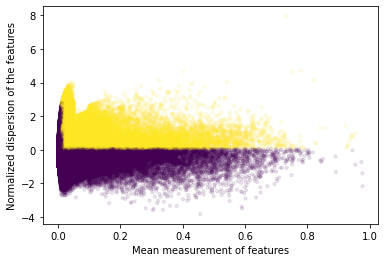

2023-03-08 17:11:42,795 cisTopic     INFO     Done!


<IPython.core.display.Javascript object>

In [11]:
print("find_highly_variable_features")
variable_regions = find_highly_variable_features(
    normalized_imputed_acc_obj,
    min_disp = 0.05,
    min_mean = 0.0125,
    max_mean = 3,
    max_disp = np.inf,
    n_bins=20,
    n_top_features=None,
    plot=True,
    save=f'plots_qc/test__HVR.png'
)

In [50]:
contrasts = []
for cell_type in cto.cell_data["harmony_consensus_cell_type__mega"].unique():
    print(cell_type)
    ct_a = "sampleA_" + cell_type.replace(" ", "_")
    ct_b = "sampleB_" + cell_type.replace(" ", "_")
    contrast = [[[ct_a], [ct_b]], [[ct_b], [ct_a]]]
    contrasts = contrasts + contrast

Cytotoxic T cell
CD4+ T cell
Natural killer cell
CD14+ monocyte
B cell
CD16+ monocyte
Dendritic cell


<IPython.core.display.Javascript object>

In [51]:
contrasts

[[['sampleA_Cytotoxic_T_cell'], ['sampleB_Cytotoxic_T_cell']],
 [['sampleB_Cytotoxic_T_cell'], ['sampleA_Cytotoxic_T_cell']],
 [['sampleA_CD4+_T_cell'], ['sampleB_CD4+_T_cell']],
 [['sampleB_CD4+_T_cell'], ['sampleA_CD4+_T_cell']],
 [['sampleA_Natural_killer_cell'], ['sampleB_Natural_killer_cell']],
 [['sampleB_Natural_killer_cell'], ['sampleA_Natural_killer_cell']],
 [['sampleA_CD14+_monocyte'], ['sampleB_CD14+_monocyte']],
 [['sampleB_CD14+_monocyte'], ['sampleA_CD14+_monocyte']],
 [['sampleA_B_cell'], ['sampleB_B_cell']],
 [['sampleB_B_cell'], ['sampleA_B_cell']],
 [['sampleA_CD16+_monocyte'], ['sampleB_CD16+_monocyte']],
 [['sampleB_CD16+_monocyte'], ['sampleA_CD16+_monocyte']],
 [['sampleA_Dendritic_cell'], ['sampleB_Dendritic_cell']],
 [['sampleB_Dendritic_cell'], ['sampleA_Dendritic_cell']]]

<IPython.core.display.Javascript object>

In [58]:
cto.cell_data["harmony_consensus_cell_type__mega"]  = [x.replace(" ", "_") for x in cto.cell_data["harmony_consensus_cell_type__mega"]]

<IPython.core.display.Javascript object>

In [59]:
cto.cell_data["fmx_sample__harmony_consensus_cell_type__mega"] = cto.cell_data["fmx_sample"] + "_" + cto.cell_data["harmony_consensus_cell_type__mega"]

<IPython.core.display.Javascript object>

In [60]:
cto.cell_data["fmx_sample__harmony_consensus_cell_type__mega"]

TCCTGAGCGAACGTCAGGGAACCGCG___OHS_s3atac_2.FIXEDCELLS                         NaN
ACGCGACGACCGGAAGAAGCACGGAC___OHS_s3atac_2.FIXEDCELLS                         NaN
GGTTAGTTCAAGTAGGACTATCGCAC___OHS_s3atac_2.FIXEDCELLS                         NaN
CTCTCTACTGAACGGCGTCTGCTTCC___OHS_s3atac_2.FIXEDCELLS                         NaN
ATTGAGGAAATGATGCTCCTGCTTCC___OHS_s3atac_2.FIXEDCELLS                         NaN
                                                                  ...           
TTCTTAGACTTCTGAG___MDC_mtscatac_1.FIXEDCELLS                 sampleB_CD4+_T_cell
CATCAGAACCCGGACT___MDC_mtscatac_1.FIXEDCELLS            sampleA_Cytotoxic_T_cell
GAACCATACTACACTG___MDC_mtscatac_1.FIXEDCELLS            sampleA_Cytotoxic_T_cell
CAGTTGATGGCACGCT___MDC_mtscatac_1.FIXEDCELLS            sampleA_Cytotoxic_T_cell
ACCTCGTTGAGTTGAA___MDC_mtscatac_1.FIXEDCELLS            sampleA_Cytotoxic_T_cell
Name: fmx_sample__harmony_consensus_cell_type__mega, Length: 169227, dtype: object

<IPython.core.display.Javascript object>

In [61]:
outpath = "merged_male_female_DARs/"

<IPython.core.display.Javascript object>

In [62]:
bcs = list(cto.cell_data[~cto.cell_data["fmx_sample__harmony_consensus_cell_type__mega"].isna()].index)

<IPython.core.display.Javascript object>

In [63]:
cto_subset = cto.subset(cells=bcs, copy=True)

<IPython.core.display.Javascript object>

In [64]:
markers_dict = find_diff_features(
    cto_subset,
    normalized_imputed_acc_obj,
    variable='fmx_sample__harmony_consensus_cell_type__mega',
    var_features=variable_regions,
    contrasts=contrasts,
    adjpval_thr=0.05,
    log2fc_thr=np.log2(1),
    n_cpu=24,
)

2023-03-08 17:52:33,345	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


(markers_ray pid=1239774) 2023-03-08 17:52:53,276 cisTopic     INFO     Formatting data for sampleA_Cytotoxic_T_cell_VS_sampleB_Cytotoxic_T_cell
(markers_ray pid=1239774) 2023-03-08 17:53:54,445 cisTopic     INFO     Computing p-value for sampleA_Cytotoxic_T_cell_VS_sampleB_Cytotoxic_T_cell


(raylet) Spilled 68663 MiB, 2 objects, write throughput 849 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.


(markers_ray pid=1239774) 2023-03-08 17:56:55,563 cisTopic     INFO     Computing log2FC for sampleA_Cytotoxic_T_cell_VS_sampleB_Cytotoxic_T_cell
(markers_ray pid=1239774) 2023-03-08 17:56:57,978 cisTopic     INFO     sampleA_Cytotoxic_T_cell_VS_sampleB_Cytotoxic_T_cell done!
(markers_ray pid=1239774) 2023-03-08 17:56:58,268 cisTopic     INFO     Formatting data for sampleB_Cytotoxic_T_cell_VS_sampleA_Cytotoxic_T_cell
(markers_ray pid=1239774) 2023-03-08 17:57:57,396 cisTopic     INFO     Computing p-value for sampleB_Cytotoxic_T_cell_VS_sampleA_Cytotoxic_T_cell
(markers_ray pid=1239774) 2023-03-08 18:00:58,247 cisTopic     INFO     Computing log2FC for sampleB_Cytotoxic_T_cell_VS_sampleA_Cytotoxic_T_cell
(markers_ray pid=1239774) 2023-03-08 18:01:00,602 cisTopic     INFO     sampleB_Cytotoxic_T_cell_VS_sampleA_Cytotoxic_T_cell done!


(raylet) Spilled 137327 MiB, 5 objects, write throughput 843 MiB/s.


(markers_ray pid=1239774) 2023-03-08 18:02:32,615 cisTopic     INFO     Formatting data for sampleA_CD4+_T_cell_VS_sampleB_CD4+_T_cell


(raylet) Spilled 205988 MiB, 6 objects, write throughput 764 MiB/s.
(raylet) Spilled 343315 MiB, 10 objects, write throughput 1176 MiB/s.
(raylet) Spilled 411977 MiB, 12 objects, write throughput 1165 MiB/s.


(markers_ray pid=1239774) 2023-03-08 18:06:52,714 cisTopic     INFO     Computing p-value for sampleA_CD4+_T_cell_VS_sampleB_CD4+_T_cell


(raylet) Spilled 480639 MiB, 14 objects, write throughput 1115 MiB/s.
(raylet) Spilled 549302 MiB, 16 objects, write throughput 1079 MiB/s.
(raylet) Spilled 617965 MiB, 18 objects, write throughput 1054 MiB/s.


(markers_ray pid=1239774) 2023-03-08 18:09:49,487 cisTopic     INFO     Computing log2FC for sampleA_CD4+_T_cell_VS_sampleB_CD4+_T_cell
(markers_ray pid=1239774) 2023-03-08 18:09:51,878 cisTopic     INFO     sampleA_CD4+_T_cell_VS_sampleB_CD4+_T_cell done!


(raylet) Spilled 686627 MiB, 20 objects, write throughput 1037 MiB/s.


(markers_ray pid=1239774) 2023-03-08 18:11:01,358 cisTopic     INFO     Formatting data for sampleB_CD4+_T_cell_VS_sampleA_CD4+_T_cell
(markers_ray pid=1239774) 2023-03-08 18:12:29,402 cisTopic     INFO     Computing p-value for sampleB_CD4+_T_cell_VS_sampleA_CD4+_T_cell
(markers_ray pid=1239774) 2023-03-08 18:15:29,825 cisTopic     INFO     Computing log2FC for sampleB_CD4+_T_cell_VS_sampleA_CD4+_T_cell
(markers_ray pid=1239774) 2023-03-08 18:15:32,262 cisTopic     INFO     sampleB_CD4+_T_cell_VS_sampleA_CD4+_T_cell done!
(markers_ray pid=1239774) 2023-03-08 18:15:32,656 cisTopic     INFO     Formatting data for sampleA_Natural_killer_cell_VS_sampleB_Natural_killer_cell
(markers_ray pid=1239774) 2023-03-08 18:15:56,790 cisTopic     INFO     Computing p-value for sampleA_Natural_killer_cell_VS_sampleB_Natural_killer_cell
(markers_ray pid=1239774) 2023-03-08 18:17:03,412 cisTopic     INFO     Computing log2FC for sampleA_Natural_killer_cell_VS_sampleB_Natural_killer_cell
(markers_ray pi

<IPython.core.display.Javascript object>

In [66]:
for contrast in markers_dict.keys():
    markers = markers_dict[contrast].index.tolist()
    df = pd.DataFrame(markers)

    if len(df) == 0:
        print(f"\t\tno DARs found for {contrast}")

    else:
        df[[0,1]] = df[0].str.split(':',expand=True)
        df[[1,2]] = df[1].str.split('-',expand=True)
        df[3] = markers_dict[contrast].index.tolist()
        df[3] = contrast.replace(' ', '_')# + '_' + df[3].astype(str)
        score = markers_dict[contrast]['Log2FC']
        score = score.reset_index(drop=True)
        df[4] = score
        df[5] = '.'
        pval = markers_dict[contrast]['Adjusted_pval']
        pval = pval.reset_index(drop=True)
        df[6] = pval
        name = contrast.replace(' ', '_')

        outpath = f"merged_male_female_DARs/{name}__1-0xfoldchange_DARs.bed"

        df.to_csv(outpath, sep='\t', header=False, index=False)
        print("printed DARs")

printed DARs
printed DARs
printed DARs
printed DARs
printed DARs
printed DARs
printed DARs
printed DARs
printed DARs
printed DARs
printed DARs
printed DARs
printed DARs
printed DARs


<IPython.core.display.Javascript object>

In [78]:
df

,0,1,2,3,4,5,6
0,chr15,40746390,40746890,sampleB_CD4+_T_cell_VS_sampleA_CD4+_T_cell,0.543617,.,8.138161e-10
1,chrX,115940714,115941214,sampleB_CD4+_T_cell_VS_sampleA_CD4+_T_cell,0.510418,.,3.776709e-05
2,chr1,244160334,244160834,sampleB_CD4+_T_cell_VS_sampleA_CD4+_T_cell,0.484846,.,1.518125e-08
3,chrX,65679108,65679608,sampleB_CD4+_T_cell_VS_sampleA_CD4+_T_cell,0.430949,.,1.215283e-04
4,chr12,120892182,120892682,sampleB_CD4+_T_cell_VS_sampleA_CD4+_T_cell,0.427286,.,2.159299e-03
...,...,...,...,...,...,...,...
15984,chr19,6110445,6110945,sampleB_CD4+_T_cell_VS_sampleA_CD4+_T_cell,0.000110,.,4.325729e-03
15985,chr2,176852531,176853031,sampleB_CD4+_T_cell_VS_sampleA_CD4+_T_cell,0.000062,.,2.185071e-05
15986,chr8,103414964,103415464,sampleB_CD4+_T_cell_VS_sampleA_CD4+_T_cell,0.000031,.,5.488424e-04
15987,chr17,3915983,3916483,sampleB_CD4+_T_cell_VS_sampleA_CD4+_T_cell,0.000023,.,2.722187e-02


<IPython.core.display.Javascript object>

In [77]:
for path in glob.glob("merged_male_female_DARs/*1-0*DARs.bed"):
    print(path)
    df = pd.read_csv(path, sep='\t', header=None, index_col=None)
    df.iloc[0:200].to_csv(path.replace('.bed', '.top200.bed'), sep='\t', index=False, header=False)

merged_male_female_DARs/sampleA_CD14+_monocyte_VS_sampleB_CD14+_monocyte__1-0xfoldchange_DARs.bed
merged_male_female_DARs/sampleA_CD4+_T_cell_VS_sampleB_CD4+_T_cell__1-0xfoldchange_DARs.bed
merged_male_female_DARs/sampleA_Cytotoxic_T_cell_VS_sampleB_Cytotoxic_T_cell__1-0xfoldchange_DARs.bed
merged_male_female_DARs/sampleB_Natural_killer_cell_VS_sampleA_Natural_killer_cell__1-0xfoldchange_DARs.bed
merged_male_female_DARs/sampleA_Natural_killer_cell_VS_sampleB_Natural_killer_cell__1-0xfoldchange_DARs.bed
merged_male_female_DARs/sampleB_CD14+_monocyte_VS_sampleA_CD14+_monocyte__1-0xfoldchange_DARs.bed
merged_male_female_DARs/sampleB_Dendritic_cell_VS_sampleA_Dendritic_cell__1-0xfoldchange_DARs.bed
merged_male_female_DARs/sampleA_CD16+_monocyte_VS_sampleB_CD16+_monocyte__1-0xfoldchange_DARs.bed
merged_male_female_DARs/sampleA_B_cell_VS_sampleB_B_cell__1-0xfoldchange_DARs.bed
merged_male_female_DARs/sampleB_Cytotoxic_T_cell_VS_sampleA_Cytotoxic_T_cell__1-0xfoldchange_DARs.bed
merged_male_fe

<IPython.core.display.Javascript object>